# U-Net by Lukas

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import layers, metrics

In [2]:
#image dimensions, seems to work with non-square inputs
IMAGE_CHANNELS = 3

IMAGE_HEIGHT =  192 #194 # 636 # 388 # 256
IMAGE_WIDTH = 64 # 70 # 229 # 140 # 128

In [3]:
seed = 4
np.random.seed = seed
random.seed(seed)

DATA_TRAIN = "./datasets/KolektorSDD2/train/"
DATA_TEST = "./datasets/KolektorSDD2/test/"



train_ids = next(os.walk(os.path.join(DATA_TRAIN, "images/")))[2]
test_ids = next(os.walk(os.path.join(DATA_TEST, "images/")))[2]


X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

# __author__ = "Sreenivas Bhattiprolu"
# __license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# # Credits https://github.com/bnsreenu/python_for_microscopists 

# """
# @author: Sreenivas Bhattiprolu
# """

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = DATA_TRAIN # + id_

    img = imread(path + 'images/' + id_)[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    X_train[n] = img  #Fill empty X_train with values from img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0        
    y_train[n] = mask 
    
# test images
test_images = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = DATA_TEST
    img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    test_images[n] = img

print('Done!')

Resizing training images and masks


  0%|          | 0/2332 [00:00<?, ?it/s]

100%|██████████| 2332/2332 [01:03<00:00, 36.59it/s]


Resizing test images


100%|██████████| 1004/1004 [00:20<00:00, 48.93it/s]

Done!


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)


x_train shape (1632, 192, 64, 3)
x_val shape (700, 192, 64, 3)
y_train shape (1632, 192, 64)
y_val shape (700, 192, 64)


In [5]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 1:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap=map,  interpolation='nearest')
    else:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [6]:
index = 0
# print(y_train.any())
# display([X_train[index], y_train[index]])
# states.index(i) for i in self.states if i == True
print([i for i in range(len(y_train)) if y_train[i].any()])

[0, 3, 5, 19, 35, 36, 40, 41, 48, 72, 73, 80, 82, 89, 100, 115, 133, 144, 152, 158, 166, 181, 218, 228, 235, 243, 245, 246, 258, 267, 290, 305, 314, 318, 327, 330, 342, 350, 352, 356, 381, 382, 400, 410, 421, 423, 424, 430, 432, 456, 469, 470, 486, 502, 511, 513, 531, 532, 535, 537, 542, 551, 562, 575, 598, 599, 607, 618, 622, 637, 640, 645, 649, 657, 665, 686, 693, 714, 726, 730, 735, 762, 766, 775, 783, 822, 825, 829, 857, 865, 869, 875, 884, 886, 893, 911, 912, 913, 916, 926, 931, 952, 958, 966, 967, 968, 973, 986, 1002, 1006, 1009, 1032, 1044, 1054, 1055, 1058, 1060, 1073, 1074, 1075, 1089, 1110, 1112, 1116, 1118, 1119, 1129, 1137, 1140, 1157, 1158, 1160, 1172, 1175, 1183, 1185, 1188, 1205, 1206, 1213, 1223, 1247, 1263, 1268, 1269, 1270, 1283, 1288, 1320, 1321, 1331, 1338, 1359, 1370, 1376, 1383, 1387, 1388, 1391, 1401, 1406, 1408, 1421, 1422, 1424, 1425, 1433, 1446, 1458, 1465, 1468, 1473, 1486, 1496, 1505, 1507, 1520, 1524, 1533, 1536, 1542, 1545, 1557, 1578, 1579, 1584, 1587, 15

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


ValueError: Expected image array to have rank 3 (single image). Got array with shape: (192, 64)

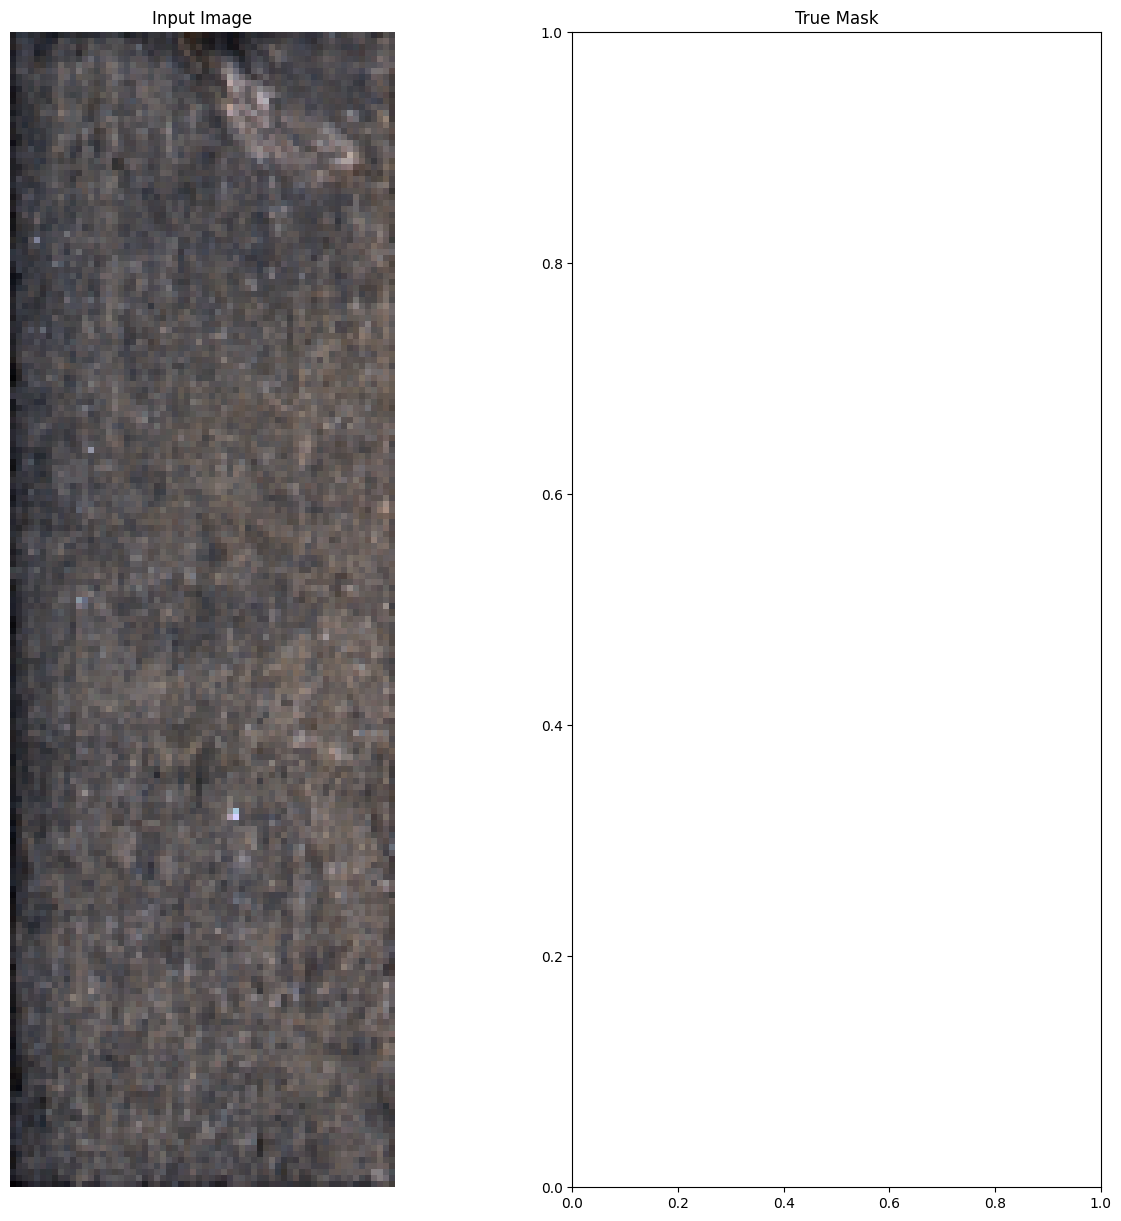

In [10]:
example = y_train[0]
example = example.astype(np.uint)
print(example)
display([X_train[0], example])

In [ ]:
#Building U-net model
#Downward stream
inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
conv_11 = layers.Conv2D(32,kernel_size=(3,3), activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(inputs)
conv_12 = layers.Conv2D(32,kernel_size=(3,3), activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_11)#TODO: Understand parameters

max_pool_1 = layers.MaxPool2D((2,2))(conv_12)
conv_21 = layers.Conv2D(64,(3,3),activation = 'relu',padding= 'same',kernel_initializer = 'he_normal')(max_pool_1)
conv_22 = layers.Conv2D(64,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_21)

max_pool_2 = layers.MaxPool2D((2,2))(conv_22)
conv_31 = layers.Conv2D(128,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(max_pool_2)
conv_32 = layers.Conv2D(128,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_31)

max_pool_3 = layers.MaxPool2D((2,2))(conv_32)
conv_41 = layers.Conv2D(256,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(max_pool_3)
conv_42 = layers.Conv2D(256,(3,3),activation = 'relu', padding= 'same')(conv_41)

max_pool_4 = layers.MaxPool2D((2,2))(conv_42)
conv_51 = layers.Conv2D(512,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(max_pool_4)
conv_52 = layers.Conv2D(512,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_51)

In [ ]:
#Upward stream
upconv_1 = layers.Conv2DTranspose(256,(2,2), strides=(2,2))(conv_52)
upconv_1_conc = layers.concatenate([upconv_1,conv_42])
conv_61 = layers.Conv2D(256,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_1_conc)
conv_62 = layers.Conv2D(256,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_61)

upconv_2 = layers.Conv2DTranspose(128, (2,2), strides = (2,2))(conv_62)
upconv_2_conc = layers.concatenate([upconv_2, conv_32])
conv_71 = layers.Conv2D(128,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_2_conc)
conv_72 = layers.Conv2D(128,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_71)

upconv_3 = layers.Conv2DTranspose(64,(2,2), strides=(2,2))(conv_72)
upconv_3_conc = layers.concatenate([upconv_3,conv_22])
conv_81 = layers.Conv2D(64,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_3_conc)
conv_82 = layers.Conv2D(64,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_81)

upconv_4 = layers.Conv2DTranspose(32,(2,2), strides=(2,2))(conv_82)
upconv_4_conc = layers.concatenate([upconv_4,conv_12])
conv_91 = layers.Conv2D(32,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_4_conc)
conv_92 = layers.Conv2D(32,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_91)
outputs = layers.Conv2D(1,(1,1), activation = 'sigmoid', padding = 'same',kernel_initializer = 'he_normal')(conv_92)#TODO: Check function here




In [ ]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate = 0.1)

In [ ]:
#Compiling model
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=[metrics.BinaryIoU()]) #TODO: Parameters check
model.summary()

Model: "model"
__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 192, 64, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 64, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 96, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

In [ ]:
epochs = 100  
batch_size = 250

history = model.fit(X_train, 
                    y_train, 
                    epochs = epochs, 
                    validation_data = (X_val, y_val), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[early_stopping]) 

Epoch 1/100
6/6 [==============================] - 19s 784ms/step - loss: 0.1562 - binary_io_u: 0.4975 - val_loss: 0.0539 - val_binary_io_u: 0.4983
Epoch 2/100
6/6 [==============================] - 2s 408ms/step - loss: 0.0673 - binary_io_u: 0.4978 - val_loss: 0.0539 - val_binary_io_u: 0.4983
Epoch 3/100
6/6 [==============================] - 2s 401ms/step - loss: 0.0673 - binary_io_u: 0.4978 - val_loss: 0.0539 - val_binary_io_u: 0.4983
Epoch 4/100
6/6 [==============================] - 2s 404ms/step - loss: 0.0673 - binary_io_u: 0.4978 - val_loss: 0.0539 - val_binary_io_u: 0.4983
Epoch 5/100
6/6 [==============================] - 2s 408ms/step - loss: 0.0673 - binary_io_u: 0.4978 - val_loss: 0.0539 - val_binary_io_u: 0.4983
Epoch 6/100
6/6 [==============================] - 2s 402ms/step - loss: 0.0673 - binary_io_u: 0.4978 - val_loss: 0.0539 - val_binary_io_u: 0.4983
Epoch 7/100
6/6 [==============================] - 2s 401ms/step - loss: 0.0673 - binary_io_u: 0.4978 - val_loss: 0.0

KeyboardInterrupt: 

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 1:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray',  interpolation='nearest')
    else:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
Y_pred = model.predict(test_images)

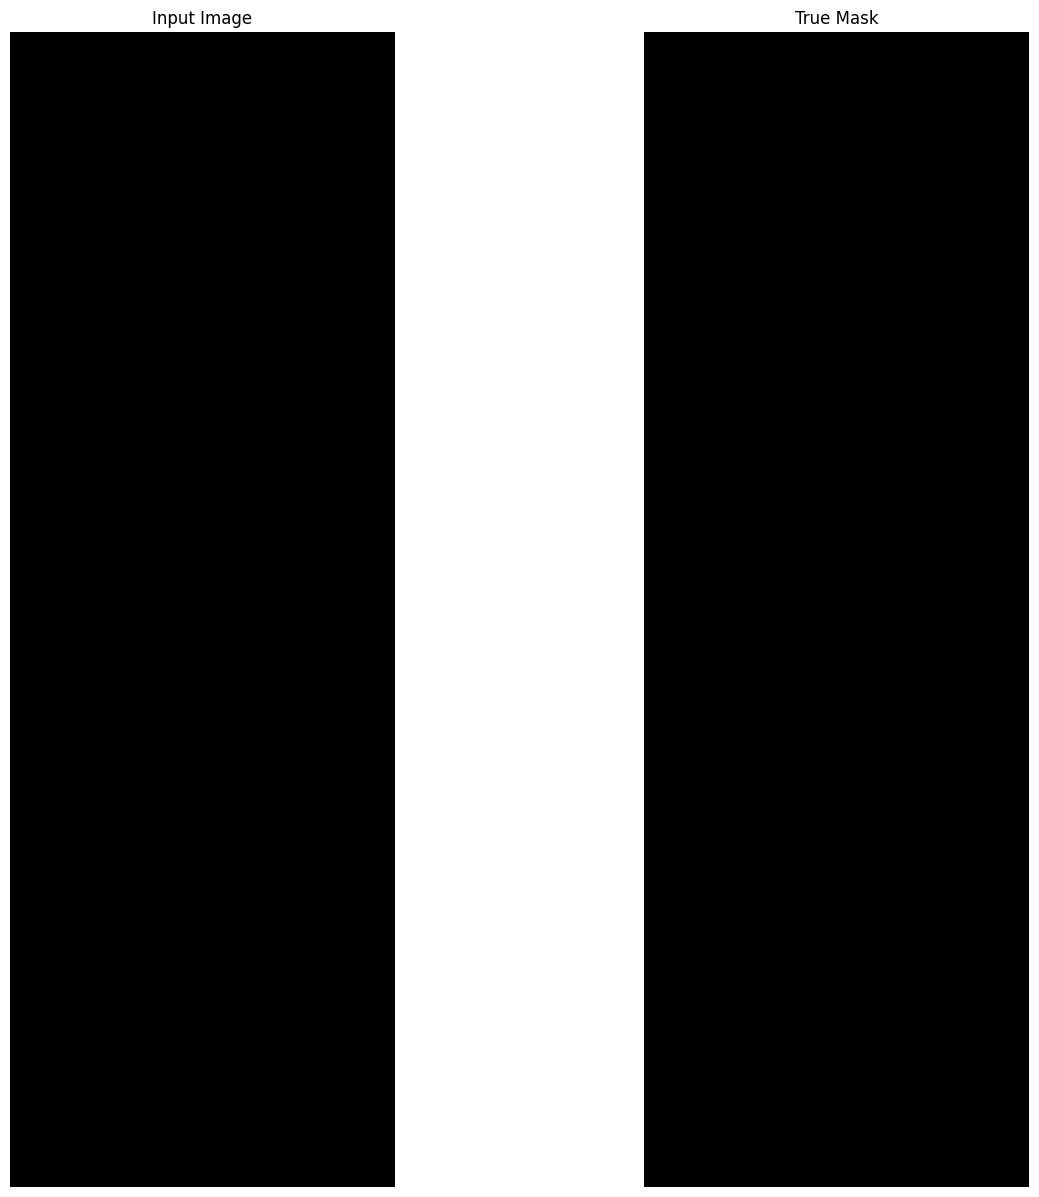

In [ ]:
display([test_images[0], Y_pred[0]])

In [ ]:
# Assuming you have 'test_labels' and 'binary_predictions'
# test_labels: True labels for the test set
# binary_predictions: Predictions made by the model (0 or 1)

Y_pred = model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, Y_pred_bin)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additional metrics
accuracy = accuracy_score(y_val, Y_pred_bin)
precision = precision_score(y_val, Y_pred_bin)
recall = recall_score(y_val, Y_pred_bin)
f1 = f1_score(y_val, Y_pred_bin)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

22/22 [==============================] - 1s 14ms/step


NameError: name 'Y_pred_bin' is not defined